In [1]:
import math

from ProjectTools import OpenBeds

In [2]:
dry = False

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount

    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    dud_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    del dud_df

    nano_hmc_df = filterDepth(nano_hmc_df)
    nano_mc_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_bed_path))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    dud_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    del dud_df

    nano_hmc_df = filterDepth(nano_hmc_df)
    nano_mc_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_tab(tab_bed_path))


In [3]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np

def mergeModDFs(mod_df1, mod_df2):
    on_list = ["chromosome", "chromStart", "chromEnd", "modification_type"]
    redundant_cols = ["method", "readCount"]

    if mod_df1["method"].str.contains("Nanopore").all() == True:
        suffixes = ["_Nano", "_BS" ]
    else:
        suffixes = ["_BS", "_Nano"]

    merged = pd.merge(mod_df1.drop(columns=redundant_cols), 
                      mod_df2.drop(columns=redundant_cols), 
                      "inner", on_list, suffixes=suffixes).reset_index(drop=True)
    
    return merged

def binBenchmark(merged_df):
    merged_df["BS_bin"] = pd.cut(merged_df["percentMeth_BS"], 20)
    return merged_df

def makeLineplot(merged_df_wBSbin):
    return pd.DataFrame(merged_df_wBSbin.groupby("BS_bin").median(numeric_only=True)["percentMeth_Nano"])

def linePlotWrapper(merged_df):
    filtered_and_merged_wBSbin_df = binBenchmark(merged_df)
    return makeLineplot(filtered_and_merged_wBSbin_df)

def ROCbinariser(merged_df, threshold):
    binariser = preprocessing.Binarizer(threshold=threshold)
    merged_df["binarised"] = binariser.fit_transform(np.reshape(merged_df["percentMeth_BS"].to_numpy(), (-1, 1)))
    return merged_df

def makeROC(binarised_df):
    fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nano"])
    return fpr, tpr

def ROCwrapper(merged_df, threshold):
    binarised_df = ROCbinariser(merged_df, threshold)
    return makeROC(binarised_df)

In [4]:
mc_binariser = preprocessing.Binarizer(threshold=50.0) # What are optimal thresholds? 

hmc_binariser = preprocessing.Binarizer(threshold=50.0)

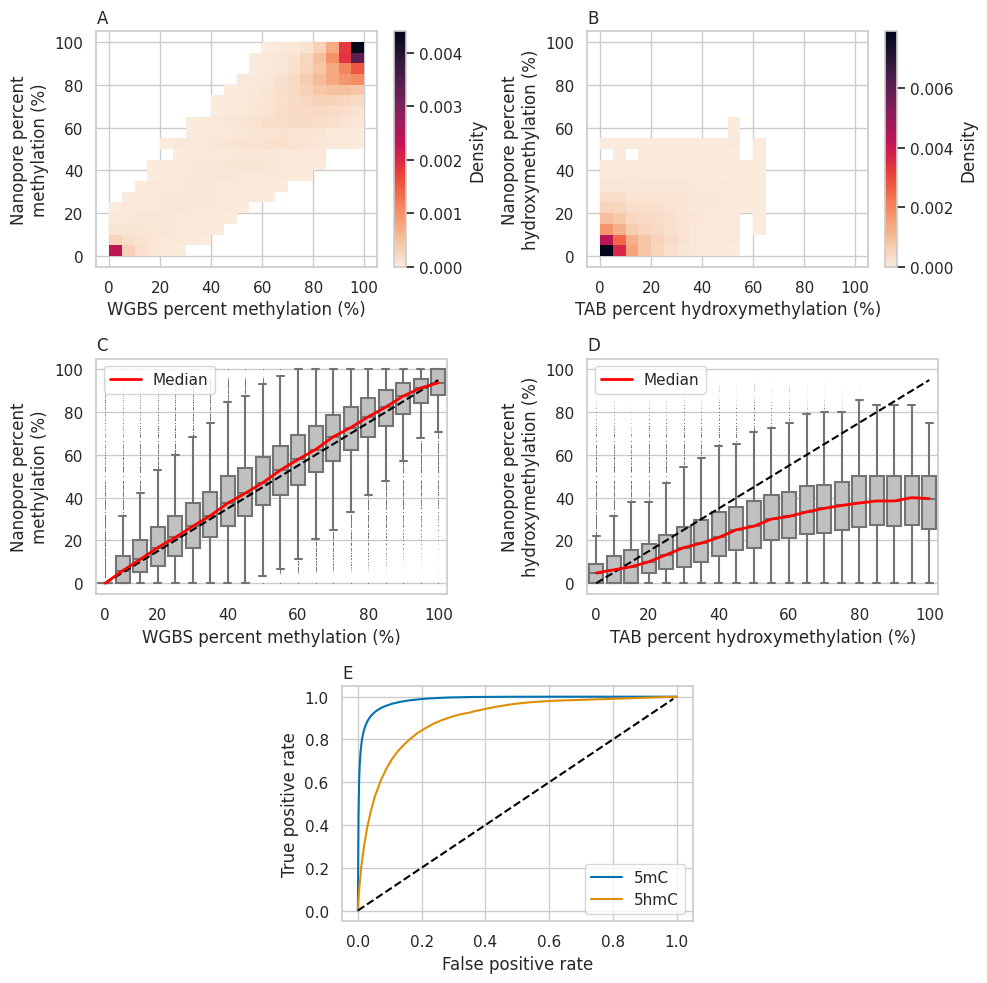

In [5]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig1 = pl.figure(figsize=(10, 10)) 
gs1 = GridSpec(3, 4, fig1)

ax1 = fig1.add_subplot(gs1[0, :2])
ax2 = fig1.add_subplot(gs1[0, 2:])
ax3 = fig1.add_subplot(gs1[1, :2])
ax4 = fig1.add_subplot(gs1[1, 2:])

merged_mc_df = mergeModDFs(nano_mc_df, wgbs_df)

sns.histplot(merged_mc_df, x="percentMeth_BS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax1, cbar_kws=dict(label="Density"))
ax1.set_xlabel("WGBS percent methylation (%)")
ax1.set_ylabel("Nanopore percent\nmethylation (%)")
ax1.set_title("A", loc="left")

merged_hmc_df = mergeModDFs(nano_hmc_df, tab_df)

sns.histplot(merged_hmc_df, x="percentMeth_BS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax2, cbar_kws=dict(label="Density"))
ax2.set_xlabel("TAB percent hydroxymethylation (%)")
ax2.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax2.set_title("B", loc="left")

sns.boxplot(binBenchmark(merged_mc_df), x="BS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax3)
ax3.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax3.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax3.set_xlabel("WGBS percent methylation (%)")
ax3.set_ylabel("Nanopore percent\nmethylation (%)")
ax3.plot(np.arange(0, 20, 1), linePlotWrapper(merged_mc_df)["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax3.legend()
ax3.set_title("C", loc="left")
sns.move_legend(ax3, "upper left")

sns.boxplot(binBenchmark(merged_hmc_df), x="BS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax4)
ax4.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax4.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax4.set_xlabel("TAB percent hydroxymethylation (%)")
ax4.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax4.plot(np.arange(0, 20, 1), linePlotWrapper(merged_hmc_df)["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax4.legend()
ax4.set_title("D", loc="left")
sns.move_legend(ax4, "upper left")

ax5 = fig1.add_subplot(gs1[2, 1:3])
ax5.plot(ROCwrapper(merged_mc_df, threshold=50)[0], ROCwrapper(merged_mc_df, threshold=50)[1], '-', label="5mC")
ax5.plot(ROCwrapper(merged_hmc_df, threshold=50)[0], ROCwrapper(merged_hmc_df, threshold=50)[1], '-', label="5hmC")
ax5.set_xlabel("False positive rate")
ax5.set_ylabel("True positive rate")
ax5.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), "black", linestyle="--")
ax5.legend()
ax5.set_title("E", loc="left")

fig1.tight_layout()

In [14]:
from scipy import stats

stats.pearsonr(merged_mc_df["percentMeth_Nano"], merged_mc_df["percentMeth_BS"])

PearsonRResult(statistic=0.9267642146866754, pvalue=0.0)

In [28]:
nano_mc_df[nano_mc_df["chromStart"] == 3070818]

,chromosome,chromStart,chromEnd,modification_type,readCount,percentMeth,method
169,chr1,3070818,3070819,5mC,25,86.96,Nanopore 5mC


In [34]:
merged_mc_df.tail()

,chromosome,chromStart,chromEnd,modification_type,percentMeth_Nano,percentMeth_BS,BS_bin,binarised
32220480,chrY,90745731,90745732,5mC,90.91,15.0,"(10.0, 15.0]",0.0
32220481,chrY,90745769,90745770,5mC,50.00,20.0,"(15.0, 20.0]",0.0
32220482,chrY,90745790,90745791,5mC,76.92,22.5,"(20.0, 25.0]",0.0
32220483,chrY,90745806,90745807,5mC,100.00,43.5,"(40.0, 45.0]",0.0
32220484,chrY,90746039,90746040,5mC,23.53,100.0,"(95.0, 100.0]",1.0


In [15]:
stats.pearsonr(merged_hmc_df["percentMeth_Nano"], merged_hmc_df["percentMeth_BS"])

PearsonRResult(statistic=0.5218785588966226, pvalue=0.0)

In [20]:
stats.ttest_ind(merged_mc_df["percentMeth_Nano"], merged_mc_df["percentMeth_BS"])

Ttest_indResult(statistic=-346.0863068835465, pvalue=0.0)

In [19]:
stats.spearmanr(merged_hmc_df["percentMeth_Nano"], merged_hmc_df["percentMeth_BS"])

SignificanceResult(statistic=0.41519231881877977, pvalue=0.0)

In [6]:
pm, rm, fm, sm = metrics.precision_recall_fscore_support(mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                        mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_Nano"].to_numpy(), (-1, 1))), average="binary")

ph, rh, fh, sh = metrics.precision_recall_fscore_support(hmc_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                        hmc_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))), average="binary")

print("Precision 5hmC: {ph}\nRecall 5hmC: {rh}\nF-Score 5hmC: {fh}\nSupport 5hmC: {sh}\n\nPrecision 5mC: {pm}\nRecall 5mC: {rm}\nF-Score 5mC: {fm}\nSupport 5mC: {sm}".format(pm=pm, rm=rm, fm=fm, sm=sm, ph=ph, rh=rh, fh=fh, sh=sh))

Precision 5hmC: 0.27633764384861786
Recall 5hmC: 0.12963624304882404
F-Score 5hmC: 0.17648117338418168
Support 5hmC: None

Precision 5mC: 0.9808718209216898
Recall 5mC: 0.9553683581382407
F-Score 5mC: 0.9679521282870933
Support 5mC: None


In [16]:
metrics.accuracy_score(mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                        mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.9481489493407688

In [17]:
metrics.roc_auc_score(hmc_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                      merged_hmc_df["percentMeth_Nano"])

0.89450212170618

In [18]:
metrics.roc_auc_score(mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                      merged_mc_df["percentMeth_Nano"])

0.9851352090156511

In [ ]:
metrics.balanced_accuracy_score(mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                mc_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.9564987610536773

In [ ]:
metrics.balanced_accuracy_score(binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.6876612929319448

In [ ]:
metrics.precision_score(binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.5180188176815196